### Data modeling of request orders

In [1]:
# Importing all the necessary libraries
import numpy as np              # Numerical array manipulation
import matplotlib.pyplot as plt # Plotting capabilities
import pymc3 as pm              # Python Monte Carlo Markov Chain package
import functionES as es         # Customized functions for this project
import seaborn as sns           # Fancy plot visualizations
import arviz as az
# import theano.tensor as tt

#  Loading data
datos = es.importing_data('OTs_detallado.sql', 7,1)

# Filtering data to keep the request orders finished
datosObservados = es.process_filter(datos)# Advanced process mining filtering
count_obs = len(datosObservados)# How many observations we have

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [25]:
count_obs
sns.set()

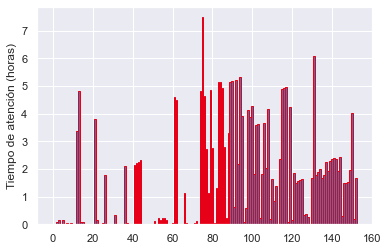

In [26]:
f = plt.figure()
ax1 = f.add_subplot(1,1,1)

ax1.bar(np.arange(len(datosObservados)),datosObservados.TiempoAtencion, edgecolor = "#E60018")
ax1.yaxis.set_label_text("Tiempo de atención (horas)")
plt.show()

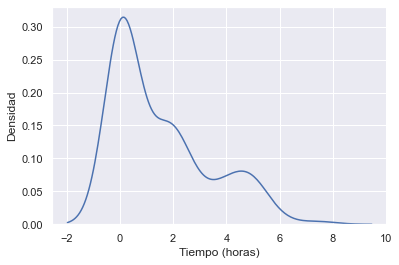

In [27]:
sns.kdeplot(datosObservados.TiempoAtencion)
plt.xlabel("Tiempo (horas)")
plt.ylabel("Densidad")
plt.show()

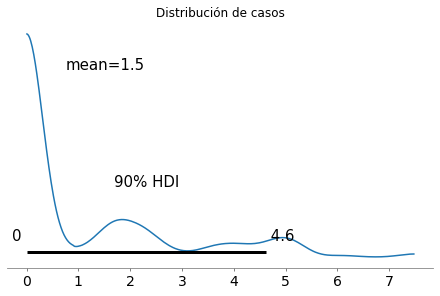

In [5]:
pm.plot_posterior(datosObservados.TiempoAtencion.to_numpy(), hdi_prob = 0.9)
plt.title("Distribución de casos")
plt.show()

In [6]:
# Generating Model context
with pm.Model() as model:
    alpha = 1.0/(datosObservados.TiempoAtencion).mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower=0, upper=count_obs-1)

# Generating lambdas (two because at some point, lambda changes its value)
with model:
    idx = np.arange(count_obs)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
# Generation Observation distribution
with model:
    observation = pm.Poisson("obs", lambda_, observed = datosObservados.TiempoAtencion)
    
# Generating simulations
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, step = step, progressbar = True)
    
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

<ipython-input-6-dbaf95f5353e>:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, step = step, progressbar = True)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2391 seconds.
The number of effective samples is smaller than 25% for some parameters.


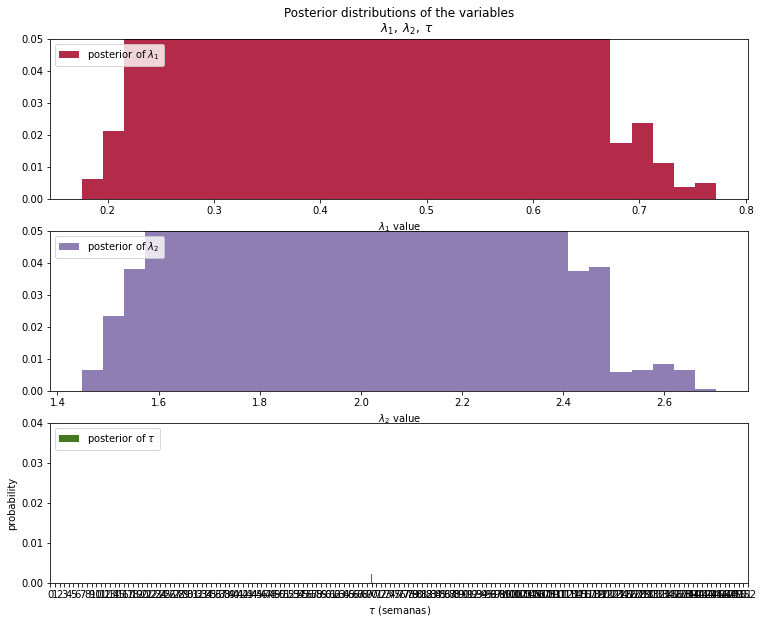

In [7]:
plt.subplots(figsize = (12.5, 10))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
# plt.xlim([15, 30])
plt.ylim([0,0.05])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
# plt.xlim([15, 30])
plt.ylim([0,0.05])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=count_obs, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(count_obs))

plt.legend(loc="upper left")
# plt.ylim([0, 0.04])
# plt.xlim([35, count_obs-20])
plt.xlabel(r"$\tau$ (semanas)")
plt.ylabel("probability");

plt.show()

C:\Users\430008252\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


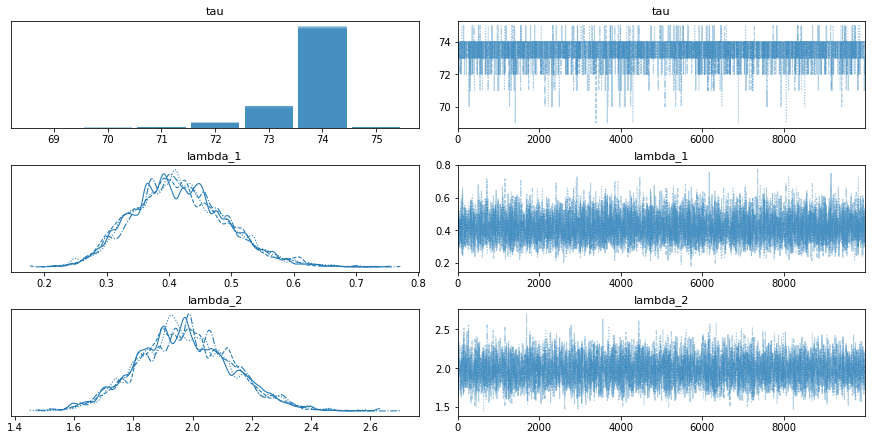

In [8]:
az.plot_trace(trace)
plt.show()

In [9]:
pm.summary(trace)

C:\Users\430008252\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,73.736,0.603,73.000,74.000,0.010,0.007,4573.0,4714.0,1.0
lambda_1,0.417,0.075,0.281,0.559,0.001,0.001,7128.0,6632.0,1.0
lambda_2,1.975,0.159,1.681,2.277,0.002,0.002,5397.0,6188.0,1.0


In [10]:
with model:
    posterior_predictive= pm.fast_sample_posterior_predictive(trace)

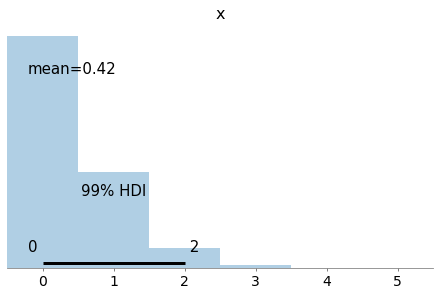

In [11]:
az.plot_posterior(posterior_predictive["obs"][:,0], hdi_prob = 0.99)
plt.show()

C:\Users\430008252\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


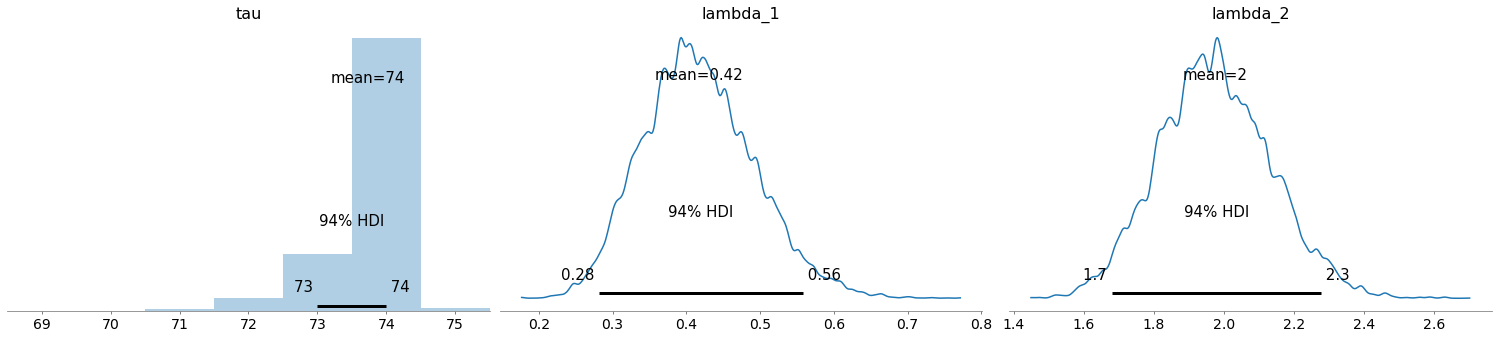

In [12]:
az.plot_posterior(trace)
plt.show()

C:\Users\430008252\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


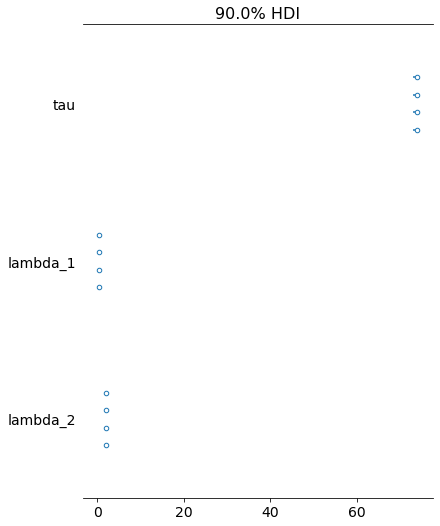

In [13]:
import arviz as az
az.plot_forest(trace, hdi_prob = 0.9)
plt.show()

In [14]:
values = az.hdi(trace, hdi_prob = 0.9)
print(values)

C:\Users\430008252\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<xarray.Dataset>
Dimensions:   (hdi: 2)
Coordinates:
  * hdi       (hdi) <U6 'lower' 'higher'
Data variables:
    tau       (hdi) float64 73.0 74.0
    lambda_1  (hdi) float64 0.2961 0.5377
    lambda_2  (hdi) float64 1.694 2.216


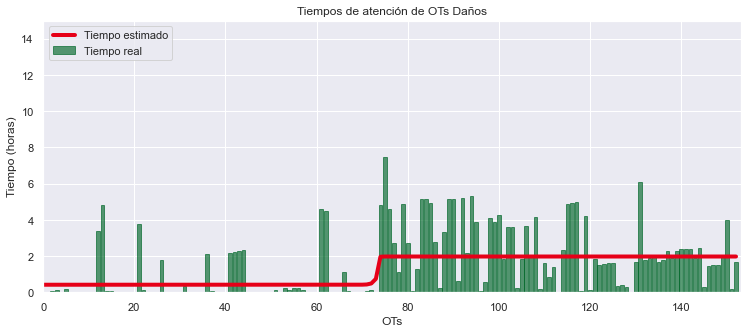

In [28]:
plt.subplots(figsize = (12.5, 5))
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
tiempoEstimadoOT = np.zeros(count_obs)
for day in range(0, count_obs):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    tiempoEstimadoOT[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N
    
plt.plot(range(count_obs), tiempoEstimadoOT, lw=4, color="#E60018",
         label="Tiempo estimado")
plt.xlim(0, count_obs)
plt.xlabel("OTs")
plt.ylabel("Tiempo (horas)")
plt.title("Tiempos de atención de OTs Daños")
plt.ylim(0, 15)
plt.bar(np.arange(len(datosObservados.TiempoAtencion)), datosObservados.TiempoAtencion , color = "#006729", edgecolor = "#006729", alpha=0.65,
        label="Tiempo real")

plt.legend(loc="upper left");

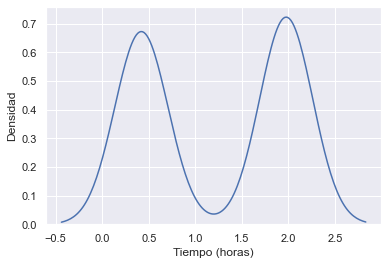

In [16]:
sns.set()
sns.kdeplot(tiempoEstimadoOT)
plt.xlabel("Tiempo (horas)")
plt.ylabel("Densidad")
plt.show()